# Figure 1

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas,matplotlib

Etienne Ackermann, Thu Apr 19 2018 13:26:12 

CPython 3.5.4
IPython 6.2.1

nelpy 0.1.2
numpy 1.11.3
scipy 0.19.0
pandas 0.19.2
matplotlib 2.1.2


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage.filters
import os
import sys
import warnings
import numpy as np
import pickle
import time
import random
import seaborn as sns
import scipy.stats as stats

import copy

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy.decoding import k_fold_cross_validation

import nelpy as nel
import nelpy.analysis
import nelpy.io # add additional functionality to nelpy on an as-needed basis
import nelpy.plotting as npl

npl.setup()

%matplotlib inline

from nelpy.hmmutils import PoissonHMM

warnings.filterwarnings("ignore")

/home/etienne/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
datadirs = ['data/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl(fileroot + 'fig1.nel')
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar


# Define example session

In [3]:
session = '16-40-19'; segment = 'short' # 'long' or 'short'

# Figure 1.a

In [5]:
all_units = aux_data[session][segment]['PBEs_noIN'].unit_ids
tc_placecells = aux_data[session][segment]['tc_placecells_noIN']                                                     
new_order = tc_placecells.get_peak_firing_order_ids() 
remaining_units = list(set(all_units) - set(new_order))
new_order.extend(remaining_units)

st = exp_data[session]['spikes_noIN']._unit_subset(aux_data[session][segment]['PBEs_noIN'].unit_ids)[nel.EpochArray([1540, 1560])]
st = st.reorder_units_by_ids(new_order)

placecell_ids = tc_placecells.unit_ids
remaining_units = list(set(st.unit_ids) - set(placecell_ids))

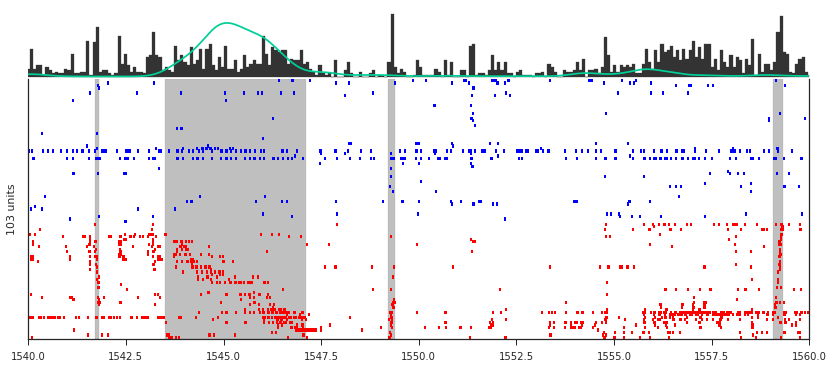

In [8]:
axc, axr = npl.rastercountplot(st, 
                    vertstack=True, 
                    lw=0, 
                    lh=1.25,
                    color='0.2',
                    nbins=250)

npl.rasterplot(st[:,placecell_ids], 
               vertstack=True, 
               lw=2, 
               lh=1.25,
               color='r',
               ax=axr)

npl.rasterplot(st[:,remaining_units], 
               vertstack=True, 
               lw=2, 
               lh=1.25,
               color='b',
               ax=axr)

npl.epochplot(aux_data[session][segment]['PBEs_noIN'][[52,53,54]].support, hatch='')
npl.epochplot(aux_data[session][segment]['st_run_noIN'].support, hatch='')
axr.set_xlim(1540,1560)
axc.set_xlim(1540,1560)
npl.plot(exp_data[session]['speed'][nel.EpochArray((1540,1560))]/2, ax=axc)


npl.utils.no_yticklabels(axr)
npl.utils.no_yticks(axr)
axr.set_ylabel('{} units'.format(aux_data[session][segment]['PBEs_noIN'].n_units))

fig = plt.gcf()

# npl.savefig('fig1a-reordered', formats=['pdf', 'png', 'svg'], fig=fig, dpi=300)

# Train HMM on example session PBEs

In [10]:
## Train HMM for particular session using all PBEs; get lsPF, and reorder both lsPF
## and HMM states by peak firing loc on track

num_states = 30 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
ds_run = 0.1
ds_50ms = 0.05
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

st = aux_data[session][segment]['st_run_noIN']
PBEs = aux_data[session][segment]['PBEs_noIN']
st_no_ripple = st[~exp_data[session]['mua_epochs']]
st_no_ripple = st_no_ripple._unit_subset(PBEs.unit_ids)
pos = exp_data[session]['pos1d'] 

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_no_ripple = st_no_ripple.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

ext_nx=124
x0=0; xl=310;
xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

# train HMM on all training PBEs
hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
hmm.fit(PBEs)

# reorder states according to transmat ordering
transmat_order = hmm.get_state_order('transmat')
hmm.reorder_states(transmat_order)

xpos = pos.asarray(at=bst_no_ripple.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)

vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc = vtc.smooth(sigma=sigma_tc)

states_in_track_order = np.array(vtc.get_peak_firing_order_ids())-1

vtc.reorder_units(inplace=True)

hmm.reorder_states(states_in_track_order) # careful with this! VTCs and hmms can get out of sync, since state IDs are not persistent

neworder = hmm.get_state_order()
hmm.reorder_states(neworder)

# Figure 1.c,d

In [11]:
neworder = hmm.get_state_order()
hmm.reorder_states(neworder)

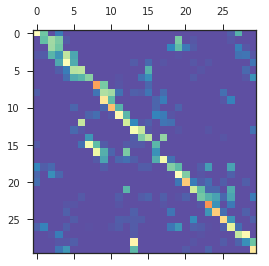

In [12]:
plt.matshow(hmm.transmat, cmap=plt.cm.Spectral_r, vmin=0, vmax=1)

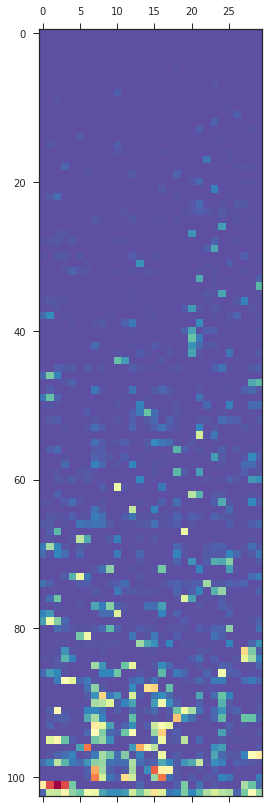

In [13]:
neworder = np.argsort(hmm.means.sum(axis=0))
plt.matshow(hmm.means[:,neworder].T, cmap=plt.cm.Spectral_r)

# Figure 1.b

In [19]:
def plot_raster_state(aux_data, exp_data, session, segment, PBEidx, st_order='track', state_order='lsPF', allcells=False):
    """
    
    st_order = ['track', 'first', 'random']
    state_order = ['lsPF', 'event', 'random', 'transmat']
    allcells: bool
        Only show place cells when False, otherwise show spikes from all cells. Default is False.
    """
    PBEidx.sort()
    bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
    if allcells:
        st = exp_data[session]['spikes_noIN']
    else:
        st = aux_data[session][segment]['st_placecells_noIN']
    tc = aux_data[session][segment]['tc_noIN']
    tc_placecells = aux_data[session][segment]['tc_placecells_noIN']
    hmm = aux_data[session][segment]['hmm']
    
    if state_order=='event':
        hmm = reorder_hmm_by_evt(hmm, bst)
    elif state_order=='transmat':
        hmm = copy.deepcopy(hmm)
        new_order = hmm.get_state_order(method='transmat')
        hmm.reorder_states(new_order)
    elif state_order=='lsPF':
        hmm = copy.deepcopy(hmm)
        new_order = hmm.get_state_order(method='mean')
        hmm.reorder_states(new_order)
    elif state_order=='random':
        hmm = copy.deepcopy(hmm)
        new_order = np.random.permutation(hmm.get_state_order())
        hmm.reorder_states(new_order)
    else:
        hmm = copy.deepcopy(hmm)
        hmm.reorder_states(state_order)

    st_cut = st[bst.support]
    st_cut = nel.utils.collapse_time(st_cut)
    
    if st_order == 'track':
        if not allcells:
            new_order = tc_placecells.get_peak_firing_order_ids()
        else:
            all_units = st.unit_ids
            new_order = tc_placecells.get_peak_firing_order_ids() 
            remaining_units = list(set(all_units) - set(new_order))
            new_order.extend(remaining_units)
    elif st_order == 'first':
        new_order = st_cut.get_spike_firing_order()
    elif st_order == 'random':
        new_order = np.random.permutation(st.unit_ids)
    else:
        new_order = st_order
    st_cut.reorder_units_by_ids(new_order, inplace=True)
    
    _, posterior_states = hmm.score_samples(bst)
    posterior = np.hstack(posterior_states)

    fig, ax = plt.subplots(figsize=(bst.n_bins/5, 4))    
    
    pixel_width = 0.5

    npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(311), data=posterior, cmap=plt.cm.gray_r, ax=ax)
    npl.utils.yticks_interval(310)
    npl.utils.no_yticks(ax)

    ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle=':', color='0.8')
    ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

    ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)

    event_centers = np.insert(np.cumsum(bst.lengths),0,0)
    event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

    ax.set_xticks([0, bst.n_bins-1]);
    ax.set_xticklabels([1, bst.n_bins]);

    npl.utils.no_xticks(ax)

    divider = make_axes_locatable(ax)
    axRaster = divider.append_axes("top", size=1.5, pad=0)

    if allcells:
        placecell_ids = tc_placecells.unit_ids
        remaining_units = list(set(st_cut.unit_ids) - set(placecell_ids))
        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=2.5, lw=2.5, color='none')
        npl.rasterplot(st_cut[:,placecell_ids], vertstack=True, ax=axRaster, lh=2.5, lw=2.5, color='r')
        npl.rasterplot(st_cut[:,remaining_units], vertstack=True, ax=axRaster, lh=2.5, lw=2.5, color='b')
    else:
        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=1.25, lw=2.5, color='0.1')

    axRaster.set_xlim(st_cut.support.time.squeeze())
    bin_edges = np.linspace(st_cut.support.time[0,0],st_cut.support.time[0,1], bst.n_bins+1)
    axRaster.vlines(bin_edges, *axRaster.get_ylim(), lw=1, linestyle=':', color='0.8')
    axRaster.vlines(bin_edges[np.cumsum(bst.lengths)], *axRaster.get_ylim(), lw=1, color='0.2')
    npl.utils.no_xticks(axRaster)
    npl.utils.no_xticklabels(axRaster)
    npl.utils.no_yticklabels(axRaster)
    npl.utils.no_yticks(axRaster)
    ax.set_ylabel('position [cm]')
    ax.set_xlabel('time bins (20 ms)')
    npl.utils.clear_left_right(axRaster)
    npl.utils.clear_top_bottom(axRaster)
    print("{}: PBE {} ({:2.3f}--{:2.3f} s)".format(session, PBEidx, bst.support.start, bst.support.stop))
        
    return fig
        

In [20]:
def reorder_hmm_by_evt(hmm, evt):
    """evt is a bst"""
    import copy
    def list_unique(seq):
        """Remove duplicate from list while keeping order
        Required arguments:
            seq: A list containing all objects
        Returns:
            A list with only unique values. Only the first occurence is kept.
        """
        def filter_uniques(seq):
            # We use set() since it's faster at lookups.
            seen = set()
            for x in seq:
                if x in seen:
                    continue
                seen.add(x)
                yield x

        return list(filter_uniques(seq))

    hmm = copy.deepcopy(hmm)
    
    states = np.hstack(hmm.predict(evt))

    neworder = list_unique(list(states) + list(range(hmm.n_components)))
    hmm.reorder_states(neworder)
    
    return hmm

16-40-19: PBE [54, 87, 92, 93, 101, 102, 103] (1559.060--1851.874 s)


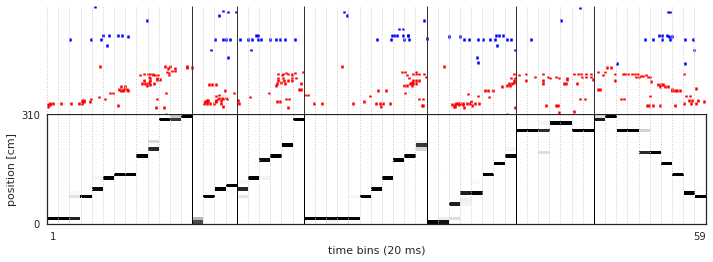

In [26]:
PBEidx=[101, 102, 103, 54, 93, 87, 92]
fig = plot_raster_state(aux_data, exp_data, session=session, segment=segment, PBEidx=PBEidx, st_order='track', state_order='lsPF', allcells=True)